In [37]:
import numpy as np
import pandas as pd
import os
import sys
import io
from os.path import join
from zipfile import ZipFile

import random as rd

import spacy
import tensorflow as tf
from IPython.core.display import display_markdown
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.models as models
from torchvision import transforms

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F

import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import FastText
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from math import ceil
from matplotlib import pyplot as plt
from PIL import Image
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import TextDisplayObject
 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Family\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Импорт датасета

In [3]:
dataset_path = 'dataset'

In [4]:
images_zip = os.path.join(dataset_path, 'train.zip')
queries = os.path.join(dataset_path, 'train.tsv')

# test_images_zip = os.path.join(dataset_path, 'test.zip')
# test_queries = os.path.join(dataset_path, 'test_no_target.tsv') # Без таргета

# example_submit = os.path.join(dataset_path, 'example_submit.tsv')

In [5]:
work_dir = 'images'

# Предобработка данных

## Получение данных из датасета

In [6]:
class PurpleFile(Exception): # Битое изображение, ошибка с CRC-32
    pass

In [7]:
def zip2jpeg(zip, png_name, dest):
  preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])
  with ZipFile(zip, 'r') as zip_file:
    if png_name in zip_file.namelist():
        try:
            zip_file.extract(png_name, path=dest)
        except:
            png_name = png_name.replace('/', '\\').replace(':', '_')
            bad_file = Image.new(mode = "RGB", size = (224, 224), color = (153, 153, 255))
            jpeg_name = png_name.replace('.png', '.jpeg')
            bad_file.save(os.path.join(dest, jpeg_name), 'JPEG', quality=50)
            print(f'Bad PNG file {png_name}')
            os.remove(os.path.join(dest, png_name))
            raise PurpleFile(f'Bad PNG file {png_name}')
            #return bad_file
    else:
      print(f'PNG file {png_name} not found in {zip}')
    png_name = png_name.replace('/', '\\').replace(':', '_')
    png_file = Image.open(os.path.join(dest, png_name)).convert('RGB')
    jpeg_name = png_name.replace('.png', '.jpeg')
    png_file.save(os.path.join(dest, jpeg_name), 'JPEG', quality=50)
    jpeg_file = Image.open(os.path.join(dest, jpeg_name)).convert('RGB')
    prep_jpeg_file = preprocess(jpeg_file)
    prep_jpeg_file.save(os.path.join(dest, jpeg_name))
    os.remove(os.path.join(dest, png_name))
    return prep_jpeg_file # JPEG

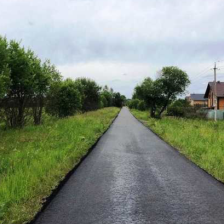

In [8]:
zip2jpeg(images_zip, 'train/competition_data:332057.png', 'images\\train_images')

In [9]:
bad_file = 'train/competition_data:322856.png'
zip2jpeg(images_zip, bad_file, 'images\\train_images')

Bad PNG file train\competition_data_322856.png


PurpleFile: Bad PNG file train\competition_data_322856.png

In [10]:
class TrainDataset(Dataset):
    def __init__(self, zip_file, tsv_file, image_dir, sample_size=-1, val_size=0.1, test_size=0.2):
        self.image_dir = image_dir
        self.zip_file = zip_file
        if sample_size == -1:
          self.data = pd.read_csv(tsv_file, sep='\t')
        else:
          self.data = pd.read_csv(tsv_file, sep='\t')
          self.data = self.data.loc[0:sample_size+1]
            
        train_data, test_data = train_test_split(self.data, test_size=test_size, random_state=42)
        val_size = val_size / (1 - test_size)
        train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=42)
        train_data = train_data.reset_index(drop=True)
        val_data = val_data.reset_index(drop=True)
        test_data = test_data.reset_index(drop=True)
        self.data = train_data
        self.val_data = val_data
        self.test_data = test_data
        
        label_to_index = {'Плохо' : 0, 'Удовлетворительно' : 1, 'Идеально' : 2}
        self.data['mark_index'] = self.data['mark'].map(label_to_index)
        self.data.drop(columns=['mark'], inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg'))):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg')))
        else:
            try:
                image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
            except PurpleFile:
                image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg')))
                self.data.iloc[idx, 1] = "bad file"
                self.data.iloc[idx, 2] = -1
          
        text = str(self.data.iloc[idx, 1])
        target = self.data.iloc[idx, 2]
        return image, str(text), target

In [11]:
class TestDataset(Dataset):
    def __init__(self, zip_file, image_dir, test_data):
        self.image_dir = image_dir
        self.zip_file = zip_file
        self.data = test_data
        label_to_index = {'Плохо' : 0, 'Удовлетворительно' : 1, 'Идеально' : 2}
        self.data['mark_index'] = self.data['mark'].map(label_to_index)
        self.data.drop(columns=['mark'], inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg'))):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg')))
        else:
          image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
        text = str(self.data.iloc[idx, 1])
        target = self.data.iloc[idx, 2]
        return image, text, target

In [12]:
def dataset_info(name, dataset):
  print('*' * len(name))
  print(name)
  print('*' * len(name))
  dataset.data.info()
  display(dataset.data.head())
  display(dataset.data.describe())
  print('_' * 75)
  for i in range(5):
    image, text, target = dataset[i]
    display(dataset.data.iloc[i])
    display(image)


In [13]:
train_dataset = TrainDataset(images_zip, queries,
                              os.path.join(work_dir, 'train_images'))

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [14]:
val_dataset = TestDataset(images_zip,
                         os.path.join(work_dir, 'val_images'), train_dataset.val_data)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [15]:
test_dataset = TestDataset(images_zip,
                           os.path.join(work_dir, 'test_images'), train_dataset.test_data)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

*****************
Обучающая выборка
*****************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18179 entries, 0 to 18178
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    18179 non-null  object
 1   text        18179 non-null  object
 2   mark_index  18179 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 426.2+ KB


,filename,text,mark_index
0,train/competition_data:332057.png,на деревне тихо,1
1,train/competition_data:329459.png,кашкай 2010,2
2,train/competition_data:103100.png,цифры,2
3,train/competition_data:280419.png,ацетат натрия,2
4,train/competition_data:243915.png,магазины бутики проекты фасады,2


,mark_index
count,18179.000000
mean,1.383960
std,0.626019
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


___________________________________________________________________________


filename      train/competition_data:332057.png
text                            на деревне тихо
mark_index                                    1
Name: 0, dtype: object

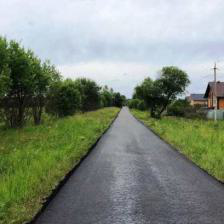

filename      train/competition_data:329459.png
text                                кашкай 2010
mark_index                                    2
Name: 1, dtype: object

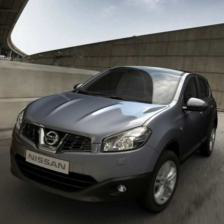

filename      train/competition_data:103100.png
text                                      цифры
mark_index                                    2
Name: 2, dtype: object

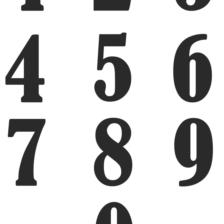

filename      train/competition_data:280419.png
text                              ацетат натрия
mark_index                                    2
Name: 3, dtype: object

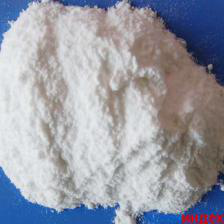

filename      train/competition_data:243915.png
text             магазины бутики проекты фасады
mark_index                                    2
Name: 4, dtype: object

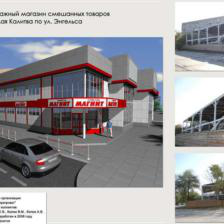

In [16]:
dataset_info('Обучающая выборка', train_dataset)

In [17]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

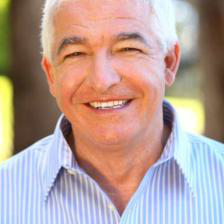

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

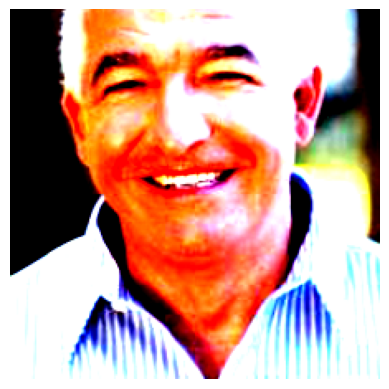

In [18]:
img = train_dataset[6][0]
display(img)

image_tensor = preprocess(img)
image_tensor_np = image_tensor.permute(1, 2, 0).numpy()
plt.imshow(image_tensor_np)
plt.axis('off')
display(plt)

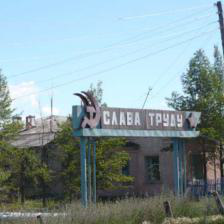

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

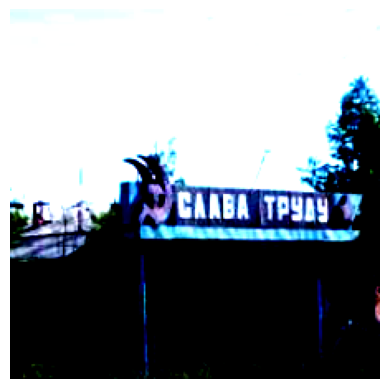

In [19]:
img = val_dataset[3][0]
display(img)

image_tensor = preprocess(img)
image_tensor_np = image_tensor.permute(1, 2, 0).numpy()
plt.imshow(image_tensor_np)
plt.axis('off')
display(plt)

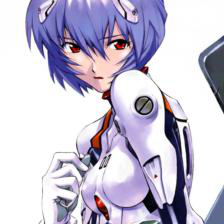

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

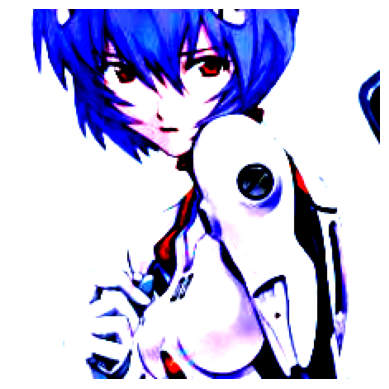

In [20]:
img = test_dataset[3][0]
display(img)

image_tensor = preprocess(img)
image_tensor_np = image_tensor.permute(1, 2, 0).numpy()
plt.imshow(image_tensor_np)
plt.axis('off')
display(plt)

In [21]:
ft_ru = FastText(language='ru')

In [22]:
text = train_dataset[6][1]

# Токенизация текста
tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
# Получение эмбеддингов слов и конкатенация
query_embeddings = [ft_ru[token] for token in tokens if token in ft_ru.stoi]
# Усреднение эмбеддингов слов для получения эмбеддинга запроса
if query_embeddings:
    avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
    vectorized_query = avg_embedding
else:
    # Если запрос состоит только из неизвестных слов, можно использовать нулевой тензор
    vectorized_query = torch.zeros(ft_ru.dim)

# Преобразование в тензоры PyTorch
vectorized_query.size()

torch.Size([300])

In [ ]:

resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad_(False)

print(list(resnet.children()))

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval()

In [38]:
img = train_dataset[7][0]
image_tensor = preprocess(img)
img_features = resnet(image_tensor.unsqueeze(0)).flatten()
img_features.size()

torch.Size([512])

## Векторизация

Создадим пробный датасет из первых 10 записей тренировочного подмножества, чтобы проверить работу генераторов эмбеддингов.

In [39]:
def img_emb_gen(dataset):
    img_emb = []
    for idx in range(len(dataset)):
      if dataset[idx][1] == "bad file":
          img_emb.append(np.array([np.nan] * 512))
      else:
          image = dataset[idx][0]
          image_tensor = preprocess(image)
          output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
          img_emb.append(output_tensor.numpy())
    img_emb_df = pd.DataFrame(img_emb, columns=[f'img_emb_{i}' for i in range(512)])
    dataset.data = pd.concat([dataset.data, img_emb_df], axis=1)

In [40]:
safe_slice = TrainDataset(images_zip, queries,
                              os.path.join(work_dir, 'train_images'), 10)

safe_slice.data.head()

,filename,text,mark_index
0,train/competition_data:69788.png,мойдодыр чуковского стихи,1
1,train/competition_data:39076.png,елена лядова биография личная жизнь муж фото дети,1
2,train/competition_data:245180.png,23 февраля нгушского народа,1
3,train/competition_data:348773.png,игры из геометрических фигур в средней группе,1
4,train/competition_data:194818.png,приседания сумо,2


In [42]:
img_emb_gen(safe_slice)
safe_slice.data.head()

,filename,text,mark_index,img_emb_0,img_emb_1,img_emb_2,img_emb_3,img_emb_4,img_emb_5,img_emb_6,...,img_emb_502,img_emb_503,img_emb_504,img_emb_505,img_emb_506,img_emb_507,img_emb_508,img_emb_509,img_emb_510,img_emb_511
0,train/competition_data:69788.png,мойдодыр чуковского стихи,1,1.286618,2.042780,0.707164,1.724844,0.993646,0.147505,1.091170,...,0.646444,0.578687,2.848514,0.636247,0.020623,0.695939,0.657074,1.300950,0.221017,3.648163
1,train/competition_data:39076.png,елена лядова биография личная жизнь муж фото дети,1,0.081124,0.487796,0.084506,0.389780,0.184029,0.714229,2.125500,...,1.290295,0.469756,0.340502,0.299844,2.391324,1.309070,2.517177,0.150856,0.307128,1.791105
2,train/competition_data:245180.png,23 февраля нгушского народа,1,0.905589,0.271512,0.407365,0.000000,0.148655,0.203434,0.189487,...,2.496955,0.000000,0.300993,0.485805,0.006021,0.629921,0.722826,1.768301,0.137771,2.860086
3,train/competition_data:348773.png,игры из геометрических фигур в средней группе,1,1.145411,0.997833,2.295359,3.884444,0.060729,0.012709,0.133870,...,0.504714,0.083051,1.063785,1.922293,0.428741,0.000000,0.179743,0.137213,0.509391,0.208310
4,train/competition_data:194818.png,приседания сумо,2,0.579469,0.174476,0.258091,0.324492,0.547961,0.205218,2.073566,...,0.028091,0.973337,0.175853,1.187411,0.280520,1.323242,0.344001,1.027756,0.003152,1.741366


In [43]:
def txt_emb_gen(dataset):
  txt_emb = []
  for idx in range(len(dataset)):
    text = dataset[idx][1]
    if text == "bad file":
        txt_emb.append(np.array([np.nan] * 300))
    else:
        # Токенизация текста
        tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
        # Получение эмбеддингов слов и конкатенация
        query_embeddings = [ft_ru[token] for token in tokens if token in ft_ru.stoi]
        # Усреднение эмбеддингов слов для получения эмбеддинга запроса
        if query_embeddings:
            avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
            vectorized_query = avg_embedding
        else:
            # Если запрос состоит только из неизвестных слов, можно использовать нулевой тензор
            vectorized_query = torch.zeros(ft_ru.dim)
        output_tensor = vectorized_query
        txt_emb.append(output_tensor.numpy())
    txt_emb_df = pd.DataFrame(txt_emb, columns=[f'txt_emb_{i}' for i in range(300)])
    dataset.data = pd.concat([dataset.data, txt_emb_df], axis=1)


In [44]:
txt_emb_gen(safe_slice)
safe_slice.data.head()

,filename,text,mark_index,img_emb_0,img_emb_1,img_emb_2,img_emb_3,img_emb_4,img_emb_5,img_emb_6,...,txt_emb_290,txt_emb_291,txt_emb_292,txt_emb_293,txt_emb_294,txt_emb_295,txt_emb_296,txt_emb_297,txt_emb_298,txt_emb_299
0,train/competition_data:69788.png,мойдодыр чуковского стихи,1,1.286618,2.042780,0.707164,1.724844,0.993646,0.147505,1.091170,...,-0.305333,0.362507,-0.014376,-0.238676,0.450763,0.007341,0.286154,-0.156111,0.024777,0.067855
1,train/competition_data:39076.png,елена лядова биография личная жизнь муж фото дети,1,0.081124,0.487796,0.084506,0.389780,0.184029,0.714229,2.125500,...,0.010964,0.088908,0.255956,0.217713,0.350814,-0.002694,0.108618,-0.066047,-0.143702,-0.091664
2,train/competition_data:245180.png,23 февраля нгушского народа,1,0.905589,0.271512,0.407365,0.000000,0.148655,0.203434,0.189487,...,0.177875,0.170020,0.085579,-0.036665,0.121124,-0.041231,-0.010864,-0.119239,0.002310,-0.019275
3,train/competition_data:348773.png,игры из геометрических фигур в средней группе,1,1.145411,0.997833,2.295359,3.884444,0.060729,0.012709,0.133870,...,0.115447,0.165504,-0.068538,-0.099851,0.106415,-0.063498,0.071625,0.038663,-0.088584,0.172612
4,train/competition_data:194818.png,приседания сумо,2,0.579469,0.174476,0.258091,0.324492,0.547961,0.205218,2.073566,...,0.272700,0.224718,-0.123558,-0.076067,0.281865,-0.004405,0.258924,-0.065039,-0.257920,0.289145


In [45]:
def emb_gen_4_entry(filename, entry):
  entry_w_emb = [filename] + list(entry[1:])
  image = entry[0]
  text = entry[1]
  
  if text == "bad file":
      entry_w_emb.extend(np.array([np.nan] * 512))
      entry_w_emb.extend(np.array([np.nan] * 300))
  else:
      image_tensor = preprocess(image)
      img_emb_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
      entry_w_emb.extend(img_emb_tensor.numpy())

      tokens = word_tokenize(text.lower())
      query_embeddings = [ft_ru[token] for token in tokens if token in ft_ru.stoi]
      if query_embeddings:
          avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
          vectorized_query = avg_embedding
      else:
          vectorized_query = torch.zeros(ft_ru.dim)
      txt_emb_tensor = vectorized_query
      entry_w_emb.extend(txt_emb_tensor.numpy())

  return entry_w_emb


In [46]:
def emb_gen(dataset):
  data_w_emb_df = pd.DataFrame(columns=['filename', 'text', 'mark_index'] + [f'img_emb_{i}' for i in range(512)] + [f'txt_emb_{i}' for i in range(300)])
  for idx in range(len(dataset)):
    emb = emb_gen_4_entry(dataset.data['filename'][idx], dataset[idx])
    data_w_emb_df.loc[len(data_w_emb_df)] = emb
  dataset.data = data_w_emb_df

In [47]:
safe_slice = TrainDataset(images_zip, queries,
                              os.path.join(work_dir, 'train_images'), 10)
safe_slice.data.head()


,filename,text,mark_index
0,train/competition_data:69788.png,мойдодыр чуковского стихи,1
1,train/competition_data:39076.png,елена лядова биография личная жизнь муж фото дети,1
2,train/competition_data:245180.png,23 февраля нгушского народа,1
3,train/competition_data:348773.png,игры из геометрических фигур в средней группе,1
4,train/competition_data:194818.png,приседания сумо,2


In [48]:
emb_gen_4_entry(safe_slice.data['filename'][0], safe_slice[0])

['train/competition_data:69788.png',
 'мойдодыр чуковского стихи',
 1,
 1.2866176,
 2.0427797,
 0.70716405,
 1.724844,
 0.9936458,
 0.1475053,
 1.0911704,
 1.7185055,
 1.7347585,
 2.5831728,
 0.8931798,
 2.7041283,
 1.6562989,
 0.17984371,
 0.06370697,
 0.7147799,
 2.6975517,
 1.4110764,
 0.30852735,
 2.2470388,
 0.092699885,
 0.14016272,
 0.19584312,
 0.27357343,
 0.13643761,
 0.7014608,
 1.0518947,
 0.8481999,
 1.5420156,
 1.3866745,
 0.93658936,
 0.86653745,
 0.060821295,
 0.36408553,
 3.3505497,
 1.3480443,
 2.0841744,
 1.2079105,
 0.3897683,
 0.68400073,
 0.8049677,
 1.3580155,
 0.77618086,
 0.8821292,
 0.80103654,
 0.638411,
 1.2519631,
 0.92144114,
 1.2850305,
 0.22306466,
 2.1557357,
 1.3234016,
 2.014776,
 0.82420254,
 0.0,
 1.7277613,
 0.25594854,
 2.9168596,
 1.1987804,
 1.6352224,
 0.8490115,
 1.3860493,
 0.28070408,
 1.3910893,
 0.87506884,
 2.212106,
 0.6765457,
 0.9889972,
 1.3240963,
 0.5523442,
 0.07382374,
 1.1148579,
 0.64716625,
 2.4517653,
 0.5119638,
 0.120860025,

In [49]:
emb_gen(safe_slice)
safe_slice.data.head()

,filename,text,mark_index,img_emb_0,img_emb_1,img_emb_2,img_emb_3,img_emb_4,img_emb_5,img_emb_6,...,txt_emb_290,txt_emb_291,txt_emb_292,txt_emb_293,txt_emb_294,txt_emb_295,txt_emb_296,txt_emb_297,txt_emb_298,txt_emb_299
0,train/competition_data:69788.png,мойдодыр чуковского стихи,1,1.286618,2.042780,0.707164,1.724844,0.993646,0.147505,1.091170,...,-0.305333,0.362507,-0.014376,-0.238676,0.450763,0.007341,0.286154,-0.156111,0.024777,0.067855
1,train/competition_data:39076.png,елена лядова биография личная жизнь муж фото дети,1,0.081124,0.487796,0.084506,0.389780,0.184029,0.714229,2.125500,...,0.010964,0.088908,0.255956,0.217713,0.350814,-0.002694,0.108618,-0.066047,-0.143702,-0.091664
2,train/competition_data:245180.png,23 февраля нгушского народа,1,0.905589,0.271512,0.407365,0.000000,0.148655,0.203434,0.189487,...,0.177875,0.170020,0.085579,-0.036665,0.121124,-0.041231,-0.010864,-0.119239,0.002310,-0.019275
3,train/competition_data:348773.png,игры из геометрических фигур в средней группе,1,1.145411,0.997833,2.295359,3.884444,0.060729,0.012709,0.133870,...,0.115447,0.165504,-0.068538,-0.099851,0.106415,-0.063498,0.071625,0.038663,-0.088584,0.172612
4,train/competition_data:194818.png,приседания сумо,2,0.579469,0.174476,0.258091,0.324492,0.547961,0.205218,2.073566,...,0.272700,0.224718,-0.123558,-0.076067,0.281865,-0.004405,0.258924,-0.065039,-0.257920,0.289145


In [265]:
emb_gen(train_dataset)
train_dataset.data.head()

Bad PNG file train\competition_data_82555.png
Bad PNG file train\competition_data_296779.png


,filename,text,mark_index,img_emb_0,img_emb_1,img_emb_2,img_emb_3,img_emb_4,img_emb_5,img_emb_6,...,txt_emb_290,txt_emb_291,txt_emb_292,txt_emb_293,txt_emb_294,txt_emb_295,txt_emb_296,txt_emb_297,txt_emb_298,txt_emb_299
0,train/competition_data:332057.png,на деревне тихо,1,0.278201,0.821032,0.166536,0.248028,0.458136,0.291936,0.235552,...,0.099019,0.541420,-0.132608,0.168968,0.214560,-0.184447,0.058822,-0.284161,-0.063549,0.362464
1,train/competition_data:329459.png,кашкай 2010,2,0.807961,2.171582,1.561773,0.130517,1.256814,0.663316,1.076345,...,-0.067523,0.504700,-0.139780,0.580410,0.409440,-0.133280,0.245420,0.219730,-0.075050,0.192140
2,train/competition_data:103100.png,цифры,2,0.105166,1.291944,0.920511,0.685790,0.277462,0.139710,0.305923,...,-0.185690,-0.166940,-0.095096,0.089881,-0.201520,-0.409880,-0.063766,0.181350,-0.387580,0.037478
3,train/competition_data:280419.png,ацетат натрия,2,0.114632,0.850897,0.119262,0.799433,0.013861,0.338646,0.153161,...,0.152187,-0.432295,-1.038065,-0.327645,0.499395,-0.220160,0.167150,-0.281115,0.020472,-0.461275
4,train/competition_data:243915.png,магазины бутики проекты фасады,2,1.204015,2.677281,3.255516,0.082253,0.513738,0.214894,0.735141,...,-0.238625,0.174530,-0.058500,-0.179674,0.239683,0.085981,0.218109,0.232022,-0.176252,-0.344548


In [266]:
output_path = 'train_embeddings.tsv'

# Записываем DataFrame в .tsv файл
train_dataset.data.to_csv(output_path, sep='\t', index=False)

In [50]:
train_dataset.data = pd.read_csv('train_embeddings.tsv', sep='\t')

In [52]:
train_dataset.data.shape

(18179, 815)

In [58]:
train_dataset.data.dropna(axis='index', how='any')

,filename,text,mark_index,img_emb_0,img_emb_1,img_emb_2,img_emb_3,img_emb_4,img_emb_5,img_emb_6,...,txt_emb_290,txt_emb_291,txt_emb_292,txt_emb_293,txt_emb_294,txt_emb_295,txt_emb_296,txt_emb_297,txt_emb_298,txt_emb_299
0,train/competition_data:332057.png,на деревне тихо,1,0.278201,0.821032,0.166536,0.248028,0.458136,0.291936,0.235552,...,0.099019,0.541420,-0.132608,0.168968,0.214560,-0.184447,0.058822,-0.284161,-0.063549,0.362464
1,train/competition_data:329459.png,кашкай 2010,2,0.807961,2.171582,1.561773,0.130517,1.256814,0.663316,1.076345,...,-0.067523,0.504700,-0.139780,0.580410,0.409440,-0.133280,0.245420,0.219730,-0.075050,0.192140
2,train/competition_data:103100.png,цифры,2,0.105166,1.291944,0.920511,0.685790,0.277462,0.139710,0.305923,...,-0.185690,-0.166940,-0.095096,0.089881,-0.201520,-0.409880,-0.063766,0.181350,-0.387580,0.037478
3,train/competition_data:280419.png,ацетат натрия,2,0.114632,0.850897,0.119262,0.799433,0.013861,0.338646,0.153161,...,0.152187,-0.432295,-1.038065,-0.327645,0.499395,-0.220160,0.167150,-0.281115,0.020472,-0.461275
4,train/competition_data:243915.png,магазины бутики проекты фасады,2,1.204015,2.677281,3.255516,0.082253,0.513738,0.214894,0.735141,...,-0.238625,0.174530,-0.058500,-0.179674,0.239683,0.085981,0.218109,0.232022,-0.176253,-0.344548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18174,train/competition_data:275516.png,планеты солнечной системы,2,2.780459,0.061001,1.292040,1.416393,1.592970,0.058712,0.787715,...,0.154016,0.219343,-0.178203,-0.105469,0.453783,0.128394,0.030061,0.179145,-0.456883,0.351367
18175,train/competition_data:343061.png,поделка тигр,2,0.065795,0.432293,0.138338,1.073202,0.036125,0.000000,0.235057,...,0.060538,-0.001080,-0.042640,0.075673,0.184790,-0.119563,-0.266780,-0.084975,0.243630,0.221775
18176,train/competition_data:223106.png,картинки населенные пункты 3 класс,1,0.002438,0.968774,0.889753,1.385631,0.106539,0.109502,0.571613,...,0.154424,-0.431487,0.301475,-0.053517,0.101021,-0.160347,0.128455,-0.012835,-0.240251,0.075549
18177,train/competition_data:255236.png,61,0,1.166634,1.433446,0.406066,0.104029,0.014446,0.037195,0.286094,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


(18179, 815)

In [60]:
train_dataset.data = train_dataset.data[train_dataset.data.text != 'bad file']
train_dataset.data.shape

(18177, 815)

## Построение бейзлайна

In [ ]:
class KombiNet(nn.Module):
    def __init__(self, num_classes):
        super(KombiNet, self).__init__()
        self.norm = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            self.norm,
        ])

        # ResNet для обработки изображений
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad_(False)
        modules = list(self.resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.resnet.eval()

        # FastText для векторизации слов
        self.ft_ru = FastText(language='ru')

        # Полносвязный слой для объединенных признаков
        self.fc_combined = nn.Linear(512 + 300, num_classes)

    def forward(self, img, text):
        # Проход изображения через ResNet
        image_tensor = self.preprocess(img)
        img_features = self.resnet(image_tensor.unsqueeze(0)).flatten()

        # Токенизация текста
        tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
        # Получение эмбеддингов слов и конкатенация
        query_embeddings = [self.ft_ru[token] for token in tokens if token in self.ft_ru.stoi]
        # Усреднение эмбеддингов слов для получения эмбеддинга запроса
        if query_embeddings:
            avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
            vectorized_query = avg_embedding
        else:
            # Если запрос состоит только из неизвестных слов, можно использовать нулевой тензор или другой метод
            vectorized_query = torch.zeros(self.ft_ru.dim)

        text_features = vectorized_query

        # Конкатенация признаков изображения и текста
        combined_features = torch.cat((img_features, text_features), dim=1)

        # Проход через полносвязный слой для объединенных признаков
        output = self.fc_combined(combined_features)
        return output


In [ ]:
def train(model, device, train_dataloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  num_epochs = 10
  for epoch in range(num_epochs):
      model.train()  # Установка модели в режим обучения
      running_loss = 0.0
      for images, texts, labels in train_dataloader:
          images = images.to(device)
          texts = texts.to(device)
          labels = labels.to(device)
          # Обнуление градиентов
          optimizer.zero_grad()
          # Прямой проход
          outputs = model(images, texts)
          # Рассчет потерь
          loss = criterion(outputs, labels)
          # Обратный проход и оптимизация
          loss.backward()
          optimizer.step()

          # Сохранение статистики
          running_loss += loss.item()

      # Вывод статистики о потерях на этапе обучения
      print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}")

  print('Обучение завершено')

In [ ]:
device = torch.device('cuda:0')
model = KombiNet(num_classes=3).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.7MB/s]


In [ ]:
train(model, device, train_dataloader)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
def validate(model, dataloader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()  # Переключение модели в режим оценки
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Отключение вычисления градиентов во время оценки
        for images, texts, labels in dataloader:
            # Перенос данных на указанное устройство
            images = images.to(device)
            texts = texts.to(device)
            labels = labels.to(device)

            # Прямой проход
            outputs = model(images, texts)

            # Рассчет потерь
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Подсчет правильных предсказаний
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Рассчет средней потери и точности
    average_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    return average_loss, accuracy

In [ ]:
validate(model, val_dataloader, device)

In [ ]:
def evaluate_accuracy(model, data_loader):
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, texts, labels in data_loader:
            images = images.to(device)
            texts = texts.to(device)
            labels = labels.to(device)
            outputs = model(images, texts)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
class TestDataset(Dataset):
    def __init__(self, zip_file, tsv_file, image_dir):
        self.image_dir = image_dir
        self.zip_file = zip_file
        self.data = pd.read_csv(tsv_file, sep='\t')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0])):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0]))
        else:
          image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
        text = self.data.iloc[idx, 1]
        return image, text

In [ ]:
test_dataset = TestDataset(test_images_zip, test_queries,
                              os.path.join(work_dir, 'test_images'))

test_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

In [ ]:
def predict(model, device, dataloader):
    model.eval()  # Установка модели в режим оценки
    predictions = []
    with torch.no_grad():  # Отключение вычисления градиентов
        for images, texts in dataloader:
            # Перемещение данных на устройство и прямой проход через модель
            images = images.to(device)
            texts = texts.to(device)
            outputs = model(images, texts)
            # Применение softmax к выходам модели
            probabilities = F.softmax(outputs, dim=1)
            # Выбор индекса класса с наибольшей вероятностью
            _, predicted = torch.max(probabilities, 1)
            predictions.extend(predicted.cpu().numpy())  # Преобразование индексов к числовому типу и добавление в список
    return images, texts, predictions

# Использование функции predict
device = torch.device('cuda:0')  # Установка устройства (GPU)
test_predictions = predict(model, device, test_dataloader)  # Получение предсказаний для тестовой выборки